# Davide Scarrà

Costituzione:
1. tema
2. (titolo)
3. cognome nome
4. (collaboratori)
5. introduzione: ambito in cui ci siamo mossi, argomento che abbiamo trattato. 5 righe
6. obbiettivi: cosa volevo fare
7. metodi/algoritmi: misto di testo e codice
8. analisi sperimentale: scelgo una batteria di dati e faccio una analisi dei risultati che ottengo rispetto a 
9. conclusioni: ho fatto questo e ha funzionato, ho fatto questo e non ha funzionato
10. fonti 

zip:
- notebook
- stampa pdf
- (estensioni di codice)

# Titolo: Confronto tra pazienti e soggetti sani

# Tema: Gait Analysis

# Introduzione

Il dataset analizzato nel notebook contiene misurazioni della poizione di alcuni punti della gamba durante la camminata in soggetti sani e pazienti. Nello specifico le colonne a coppie indicano, per ogni frame, rispettivamente la poszione sulle x e la posizione sulle y dei punti della gamba. I punti della gamba sono: anca, ginocchio, caviglia e piede

![sensori](sensori.jpg)

# Obbiettivi.
1. Pulizia dei segnali da interferenze: 
- Interpolazione
- Passa-basso
- Mediano
- Gaussiano
2. Creazione di una gif rappresentante il movimento della gamba del paziente.
3. Analisi della differenza tra il numero di passi della gamba sinistra e destra del paziente.
4. Confronto tra pazienti e soggetti sani della distanza temporale tra i passi.
5. Confronto tra pazienti e soggetti sani del tempo in cui il piede rimane poggiato a terra.
6. Analisi dell'altezza dei passi (fallito)

# Metodi e Algoritmi

In [191]:
from IPython.display import Markdown as md
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import glob
from scipy.io import loadmat
import pandas as pd
from scipy import signal
from scipy.ndimage import convolve1d
from scipy.signal import find_peaks
from sympy import *

matplotlib.rcParams['figure.figsize'] = (20, 10)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [192]:
# rimuove i nan dagli estremi del segnale
def nanRem(arr):
    start, end = 0, len(arr)-1
    while(np.isnan(arr[start])):
        start+=1
    while(np.isnan(arr[end])):
        end-=1
    newarray = np.array(arr[start:end])
    return newarray

In [193]:
# applica i filtri e convoluzione al segnale
def pulizia(segnali): 
    length = len(segnali)   
    for i in range(length):

        segnali[i]=pd.Series(segnali[i]).interpolate(method='polynomial', order=2)

        fs = 25
        fft_f = np.fft.fft(segnali[i])
        n = len(fft_f)
        freq = np.fft.fftfreq(n, 1/fs)

        idx = np.argwhere(np.abs(freq)>12)
        fft_cut=np.copy(fft_f)
        fft_cut[idx]=0

        f_cut=np.fft.ifft(fft_cut)

        filt_med=signal.medfilt(np.real(f_cut), kernel_size=7) 

        windowg = signal.windows.gaussian(23, std=10)
        windowg /= sum(windowg)
        segnali[i] = convolve1d(filt_med, windowg)

In [194]:
# crea la gif della gamba
def animate(frame):
    xdata, ydata = [], []
    for i in (0,2,4,6):
        if(frame<len(segnali[i])):
            x=segnali[i][frame]
            xdata.append(x)
           
        if(frame<len(segnali[i+1])):
            y=segnali[i+1][frame]
            ydata.append(y)
        
    line.set_data(xdata, ydata)
    return [line]

In [195]:
# trova i picchi del segnale datogli
def peaksFinder(segnali, i):
    plt.subplot(3,1,1)
    plt.title("Valori x durante la camminata")
    plt.plot(segnali[i], "r")
    plt.show()

    der=np.gradient(-segnali[i])
    plt.subplot(3,1,2)
    plt.title("Derivata prima")
    plt.plot(der)
    plt.show()

    filt_cut = der
    filt_cut += np.max(der)
    peaks, _ = find_peaks(filt_cut, np.mean(der), distance=10)

    plt.subplot(3,1,3)
    plt.title("Derivata prima del segnale con picchi evidenziati")
    plt.plot(filt_cut)
    plt.plot(peaks, filt_cut[peaks], "o")
    plt.show()

    return peaks

In [196]:
# carica un dataset e lo pulisce
def getData(patient):
    
    data = loadmat(patient)
    data_filter = data[list(data.keys())[-1]]

    anca_x = nanRem(data_filter[:,0])
    anca_y = nanRem(data_filter[:,1])
    ginocchio_x = nanRem(data_filter[:,2])
    ginocchio_y = nanRem(data_filter[:,3])
    caviglia_x = nanRem(data_filter[:,4])
    caviglia_y = nanRem(data_filter[:,5])
    piede_x = nanRem(data_filter[:,6])
    piede_y = nanRem(data_filter[:,7])

    segnali=[anca_x, anca_y, ginocchio_x, ginocchio_y, caviglia_x, caviglia_y, piede_x, piede_y]

    inverti_y(segnali)
    inverti_x(patient, segnali)
    pulizia(segnali)
    return segnali

In [197]:
# conta i frame nei quali la derivata del segnale passatogli è vicina allo 0
def frameTerra(targetPattern):
    mean=[]
    for file in (glob.glob(targetPattern)):
        #print(file)
        #carico i file
        segnali=getData(file)
        der=np.gradient(-segnali[4])
        frames=[]
        frame=0
        for point in der:
            if point<0.7 and point>-0.7:
                #plt.plot(frame,point, marker="o", color="red")
                frames.append(frame)
            frame+=1
        value=mediaTerra(np.asarray(piedeTerra(frames)))
        #tolgo valori da value = 1 poichè sono dovuti ad una errata registrazione del piede a terra
        if value!=1:
            mean.append(value)
    return(np.mean(mean)/25)

In [198]:
# calcola la medja dei frame nei quali il piede sta a terra
def mediaTerra(frames):
    media=[]
    for i in range(len(frames)):
        media.append(len(frames[i]))
    return np.mean(media)

In [199]:
# divide un array di frame in gruppi basandosi sulla distanza tra un frame e l'altro (separa un passo dall'altro)
def piedeTerra(frames):
    split=[]
    for i in range(len(frames)):
        if i < len(frames)-1:
            #se la distanza tra un frame è maggiore di 5 divido l'array
            if frames[i+1] - frames[i]  > 5:
                split.append(i+1)
    return np.array_split(frames, split)

In [200]:
# calcola l'altezzadei picchi del segnale passatogli
def altezza(y):
    peaksValue=[]
    filt_cut = y
    filt_cut += np.max(np.abs(y))
    peaks, _ = find_peaks(filt_cut, 0, distance=40)
    plt.plot(filt_cut)
    plt.plot(peaks, filt_cut[peaks], "o")
    plt.show()
    for peak in peaks:
        peaksValue.append(y[peak])
    return peaksValue

In [201]:
# conta i frame trascorsi tra un passo e l'altro
def tempoPasso(targetPattern):
    mean=[]
    for file in (glob.glob(targetPattern)):
        #print(file)
        #carico i file
        segnali=getData(file)
        #calcolo la derivata
        der=np.gradient(-segnali[4])
        filt_cut = der
        filt_cut += np.max(der)
        #trovo i picchi
        peaks, _ = find_peaks(filt_cut, np.mean(der))
        '''plt.plot(filt_cut)
        plt.plot(peaks, filt_cut[peaks], "x")
        plt.show()'''
        dist=[]
        #calcolo la distanza tra i picchi
        #se nella registrazione c'è solo un picco non ha senso calcolare la distanza
        if(len(peaks)!=1):
            for i in range(len(peaks)-1):
                dist.append(abs(peaks[i]-peaks[i+1]))
            mean.append(int(np.mean(dist)))            
    return(np.mean(mean)/25)

# Analisi Sperimentale

## Carico la matrice

In [202]:
percorso="/home/davide/Documents/FESI"
patient = '522_01_L_joints'  # nome del file (senza .mat)
# qui metti il path al file .mat sul tuo pc (compreso .mat)
data = loadmat(
    percorso+"/Pazienti/"+patient+".mat")
data_filter = data[list(data.keys())[-1]]


Do' un'occhiata ai segnali.

In [203]:
print(data_filter)

[[460.83406177 254.2894195           nan ... 352.5456921  407.80697985
  358.39570636]
 [461.25182124 255.35780747          nan ... 353.23728363 408.42316475
  359.09784197]
 [460.11234146 255.51702517          nan ... 353.48095475 408.52650474
  359.35780276]
 ...
 [         nan          nan          nan ...          nan          nan
           nan]
 [         nan          nan          nan ...          nan          nan
           nan]
 [         nan          nan          nan ...          nan          nan
           nan]]


Ci sono parecchi nan, vado a levare attraverso la funzione nanRem solo quelli agli estremi in modo da poter interpolare i valori mancanti.

Creo una matrice contenente i dati puliti.

In [204]:
anca_x = nanRem(data_filter[:,0])
anca_y = nanRem(data_filter[:,1])
ginocchio_x = nanRem(data_filter[:,2])
ginocchio_y = nanRem(data_filter[:,3])
caviglia_x = nanRem(data_filter[:,4])
caviglia_y = nanRem(data_filter[:,5])
piede_x = nanRem(data_filter[:,6])
piede_y = nanRem(data_filter[:,7])

segnali=[anca_x, anca_y, ginocchio_x, ginocchio_y, caviglia_x, caviglia_y, piede_x, piede_y]

Dopo aver diviso in liste le coordinate x e y di ogni punto e dopo aver levato i nan vado a plottare le posizioni nel tempo dei quattro punti della gamba.

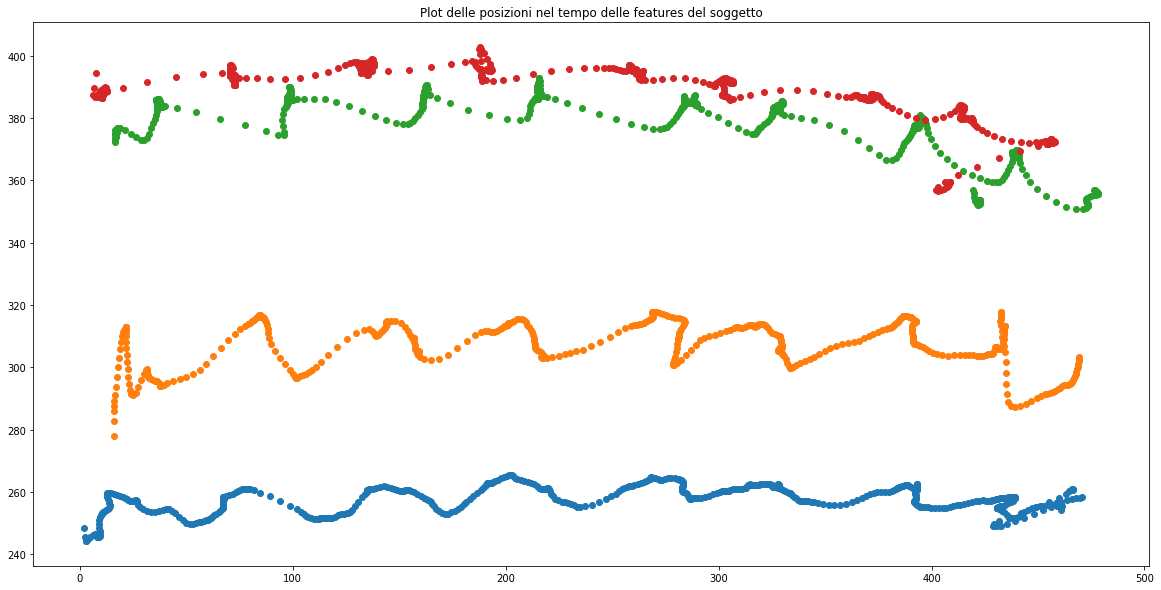

In [205]:
plt.title("Plot delle posizioni nel tempo delle features del soggetto")
for i in (0,2,4,6):
    plt.plot_date(segnali[i], segnali[i+1], xdate=False)

La prima cosa che salta all'occhio è che il grafico è "capovolto" nel senso che il piede è il punto più alto e l'anca quello più basso. Oltre a ciò vi sono dei buchi nelle linee dovuti ai nan che più avanti andrò ad interpolare.

## Inverto l'asse y:

Semplicemente prendo ogni valore degli array contenenti le y e lo sottraggo al valore massimo globale 

In [206]:
def inverti_y(segnali):
    massimo = max(np.nanmax(segnali[1]), np.nanmax(segnali[3]), np.nanmax(segnali[5]), np.nanmax(segnali[7]))
    for i in (1,3,5,7):
        segnali[i]=massimo-segnali[i]    

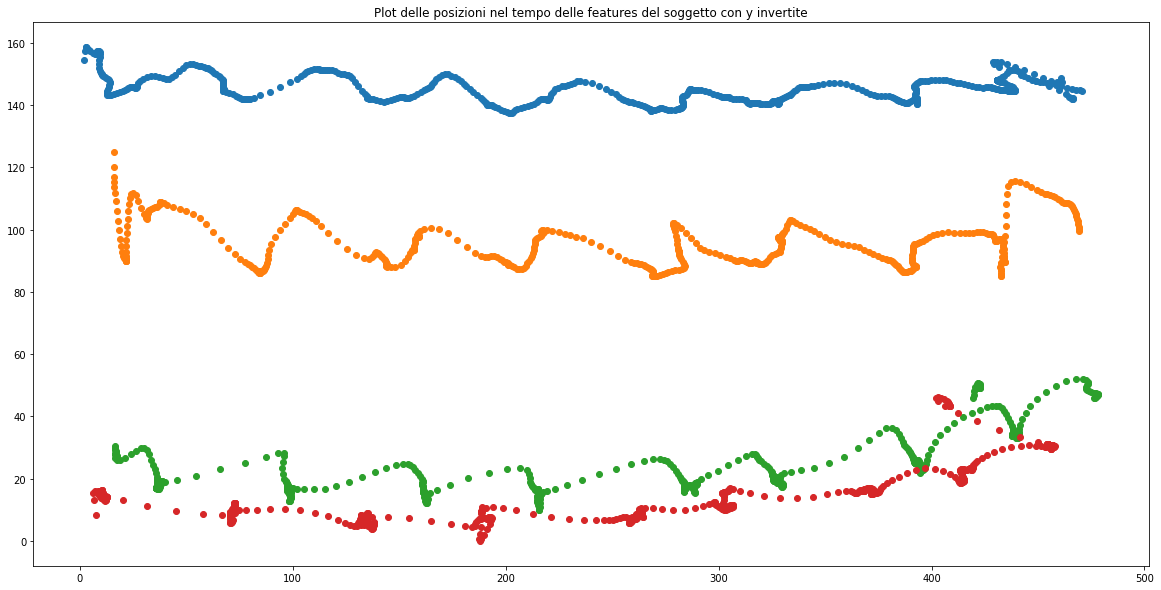

In [207]:
inverti_y(segnali)

plt.title("Plot delle posizioni nel tempo delle features del soggetto con y invertite")
for i in (0,2,4,6):
    plt.plot_date(segnali[i], segnali[i+1], xdate=False)

plt.show()

## Inverto l'asse x:

Se la gamba che sto analizzando è la destra, può essere comodo invertire l'asse x per visualizzare gamba sinistra e destra nello stesso modo.

In [208]:
def inverti_x(file, segnali):
    if "R" in file or "dx" in file:
        massimo = max(np.nanmax(segnali[0]), np.nanmax(segnali[2]), np.nanmax(segnali[4]), np.nanmax(segnali[6]))
        for i in (0,2,4,6):
            segnali[i]=massimo-segnali[i]   

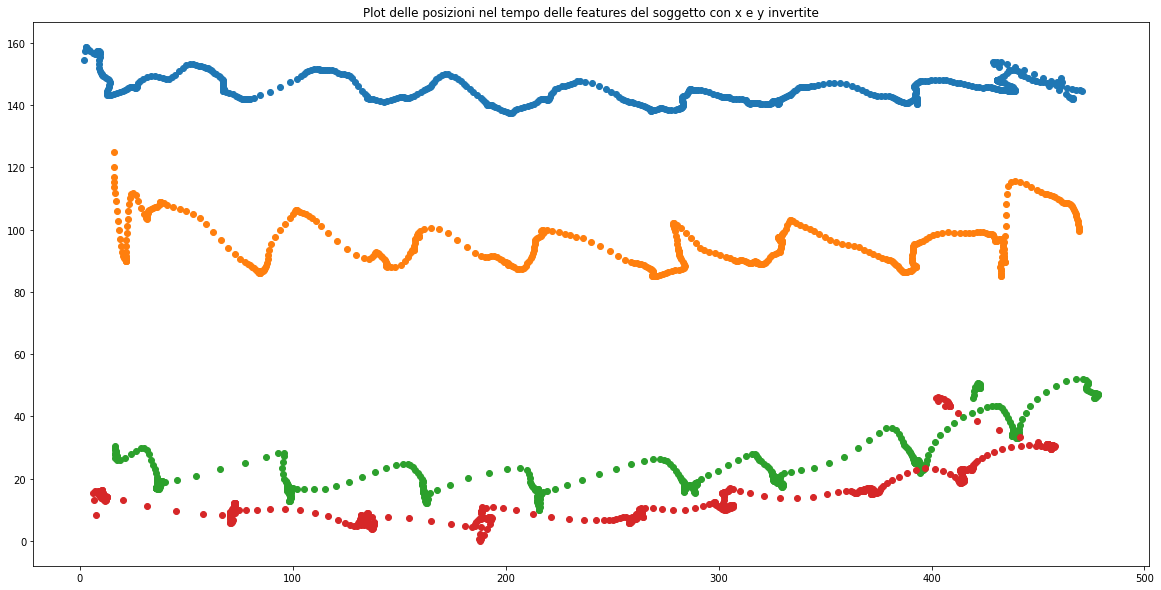

In [209]:
inverti_x(patient, segnali)

plt.title("Plot delle posizioni nel tempo delle features del soggetto con x e y invertite")
for i in (0,2,4,6):
    plt.plot_date(segnali[i], segnali[i+1], xdate=False)

plt.show()

## Correggo le interferenze con dei filtri

Ora vado a fare un po' di pulizia dei segnali...

Prendo come esempio i valori x dell'anca per far vedere come operano i filtri plottando i risultati intermedi.

## Interpolazione

Interpolo i valori mancanti con una funzione polinomiale per levare i "buchi" nei grafici.

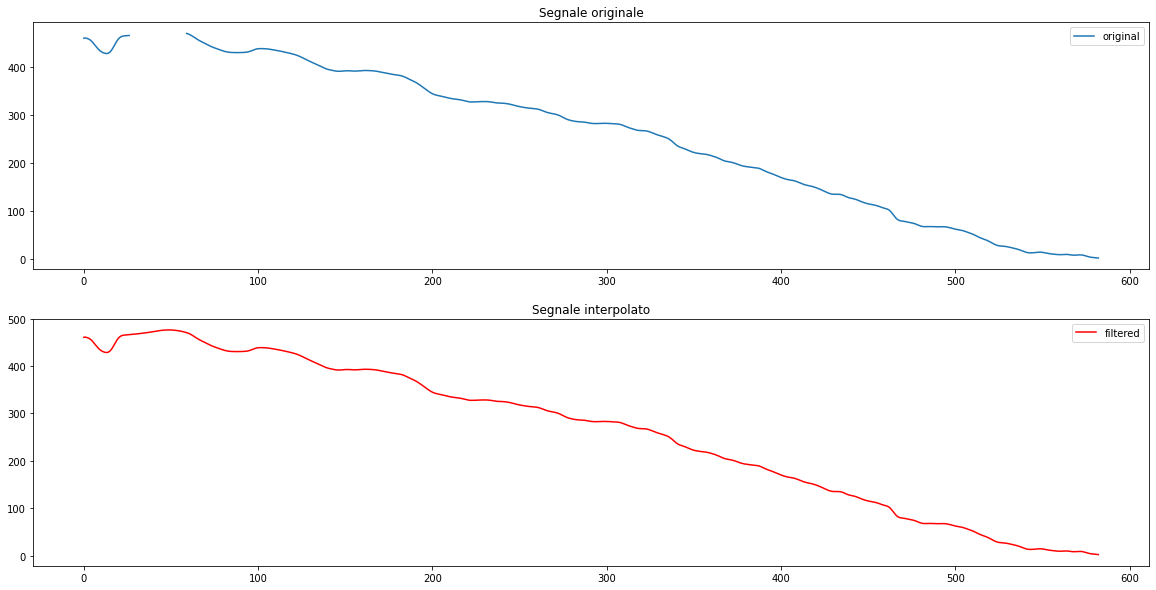

In [210]:
res=pd.Series(segnali[0]).interpolate(method='polynomial', order=2)


plt.subplot(211)
plt.title("Segnale originale")
plt.plot(segnali[0])
plt.legend(['original'])
#plt.title('original')
plt.subplot(212)
plt.title("Segnale interpolato")
plt.plot(res, 'r')
plt.legend(['filtered'])

plt.show()

## Passa-basso

Attraverso un filtro passa-basso elimino i le frequenze maggiori di 12Hz, irraggiungibili dal corpo umano.

Come prima cosa faccio la trasformata di Fourier del mio segnale:

(-1.0, 100000.0)

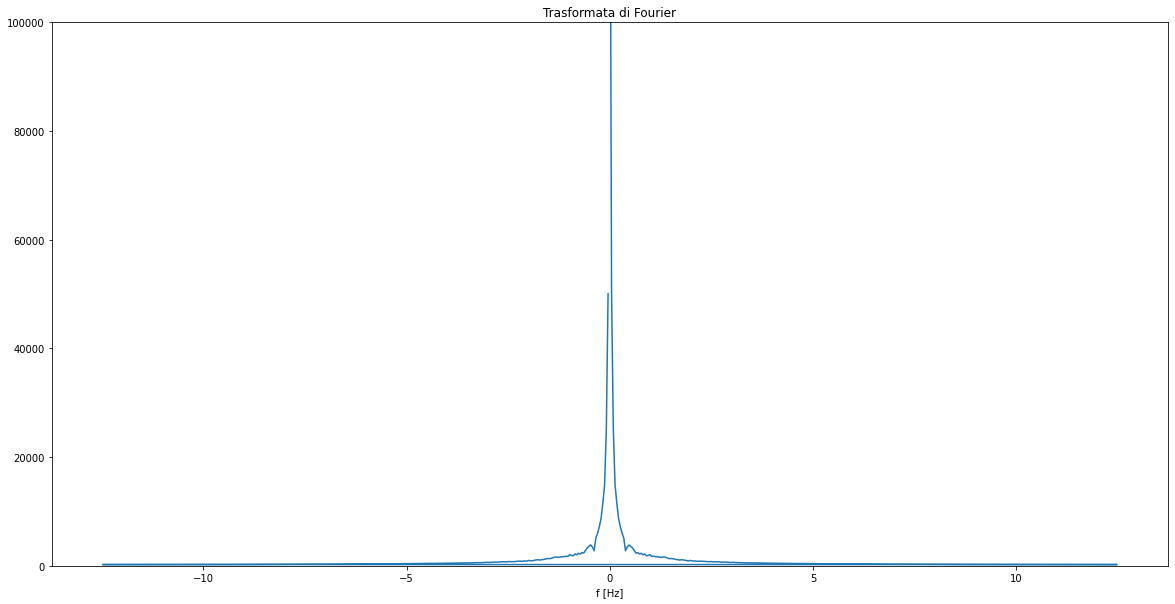

In [211]:
fs = 25
fft_f = np.fft.fft(res) #array delle y
n = len(fft_f)
freq = np.fft.fftfreq(n, 1/fs) #array conteneti indici giusti per il wrap

plt.title("Trasformata di Fourier")
plt.plot(freq,np.abs(fft_f))  
plt.xlabel('f [Hz]')
plt.ylim([-1,100000])

Ora procedo a rendere nulle le frequenze maggiori di 12Hz.

(-1.0, 100000.0)

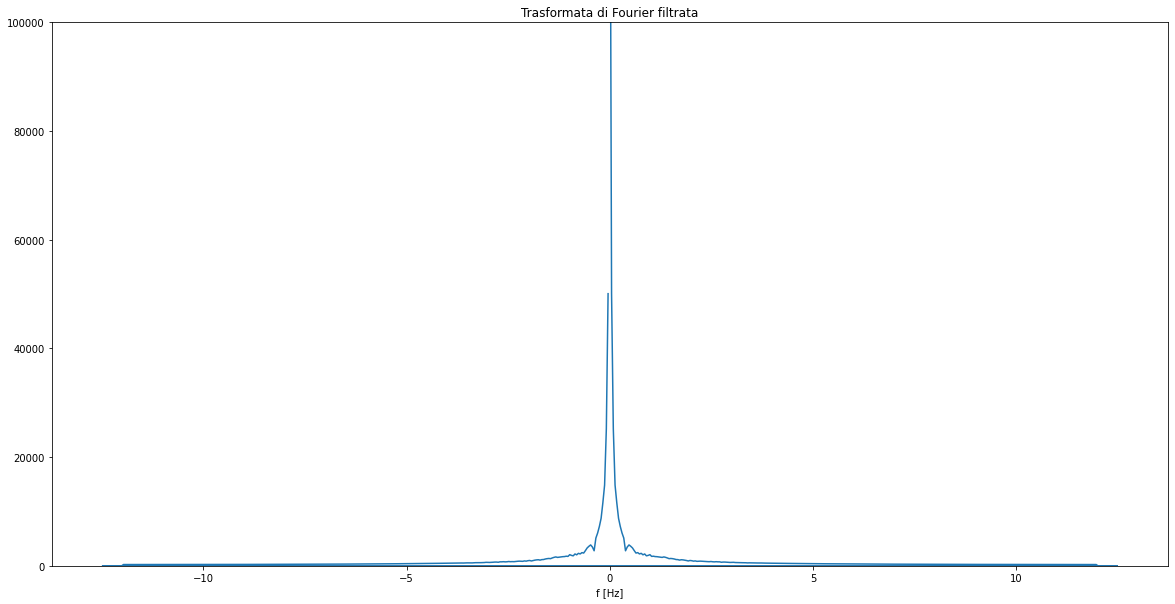

In [212]:
idx = np.argwhere(np.abs(freq)>12)
fft_cut=np.copy(fft_f)
fft_cut[idx]=0

plt.title("Trasformata di Fourier filtrata")
plt.plot(freq,np.abs(fft_cut) )
plt.xlabel('f [Hz]')
plt.ylim([-1,100000])

Infine applico una trasformata di Furier inversa e plotto il segnale pulito risultante paragonato al segnale originale.

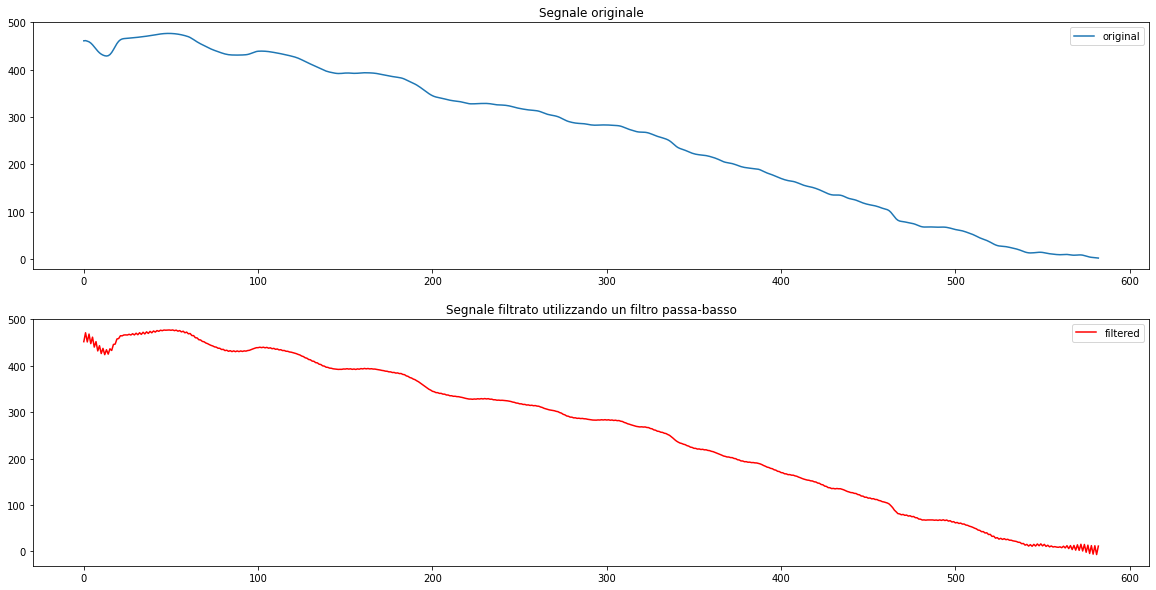

In [213]:
f_cut=np.fft.ifft(fft_cut)

plt.subplot(2,1,1)
plt.title("Segnale originale")
plt.plot(res)
plt.legend(['original'])

plt.subplot(2,1,2)
plt.title("Segnale filtrato utilizzando un filtro passa-basso")
plt.plot(np.real(f_cut),'r')
plt.legend(['filtered'])

plt.show()

I segnali sono pressochè identici, anzi attraverso il filtro abbiamo introdotto dei disturbi agli estremi del segnale.

## Mediano

Applico ora un filtro mediano per levare eventuali spike localizzati dovuti ad errori nella raccolta dei movimenti.

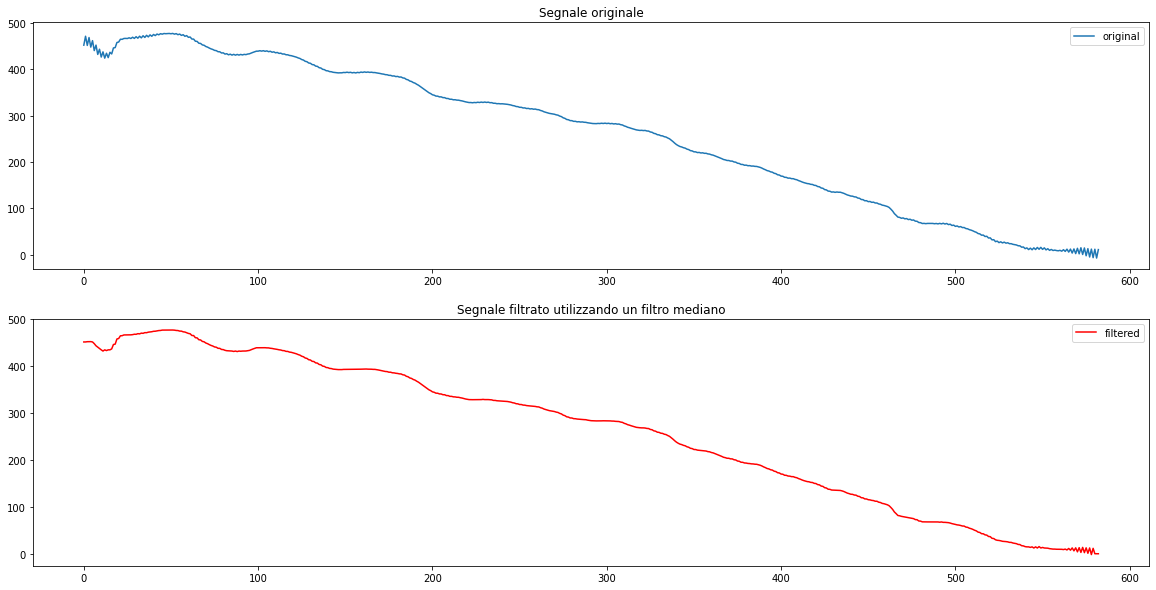

In [214]:
filt_med=signal.medfilt(np.real(f_cut), kernel_size=7)

plt.subplot(2,1,1)
plt.title("Segnale originale")
plt.plot(np.real(f_cut))
plt.legend(['original'])

plt.subplot(2,1,2)
plt.title("Segnale filtrato utilizzando un filtro mediano")
plt.plot(np.real(filt_med),'r')
plt.legend(['filtered'])
plt.show()

## Gaussiano

Infine applico un filtro gaussiano per rendere più "smooth" il segnale e levare, oltre alle altre, le interferenze aggiunte dal filtro passa-basso.

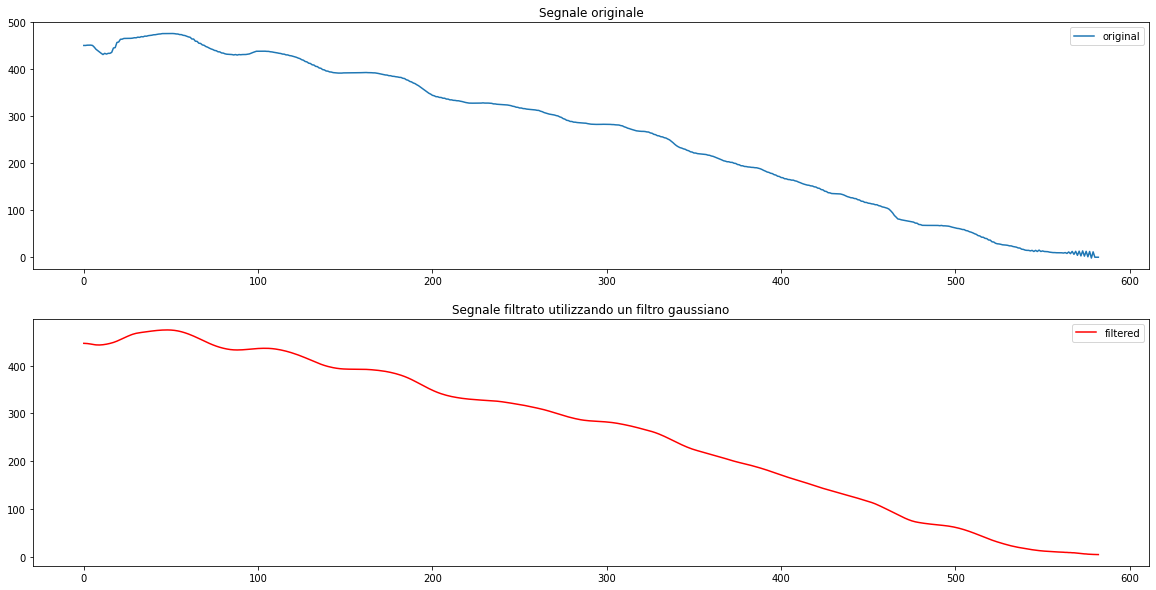

In [215]:
windowg = signal.windows.gaussian(23, std=10) #cambiare valori della gaussian
windowg /= sum(windowg)
filt = convolve1d(filt_med, windowg)

plt.subplot(2,1,1)
plt.title("Segnale originale")
plt.plot(np.real(filt_med))
plt.legend(['original'])

plt.subplot(2,1,2)
plt.title("Segnale filtrato utilizzando un filtro gaussiano")
plt.plot(filt, 'r')
plt.legend(['filtered'])
plt.show()

## Filtri applicati sugli altri segnali

Ora faccio le stesse operazioni su tutti gli altri segnali (anca_y , ginocchio_x, ginocchio_y, caviglia_x, caviglia_y, piede_x e piede_y).

In [216]:
pulizia(segnali)

A questo punto tutti i miei segnali sono puliti e pronti per essere analizzati.

## Plot

Plotto i mei segnali puliti.

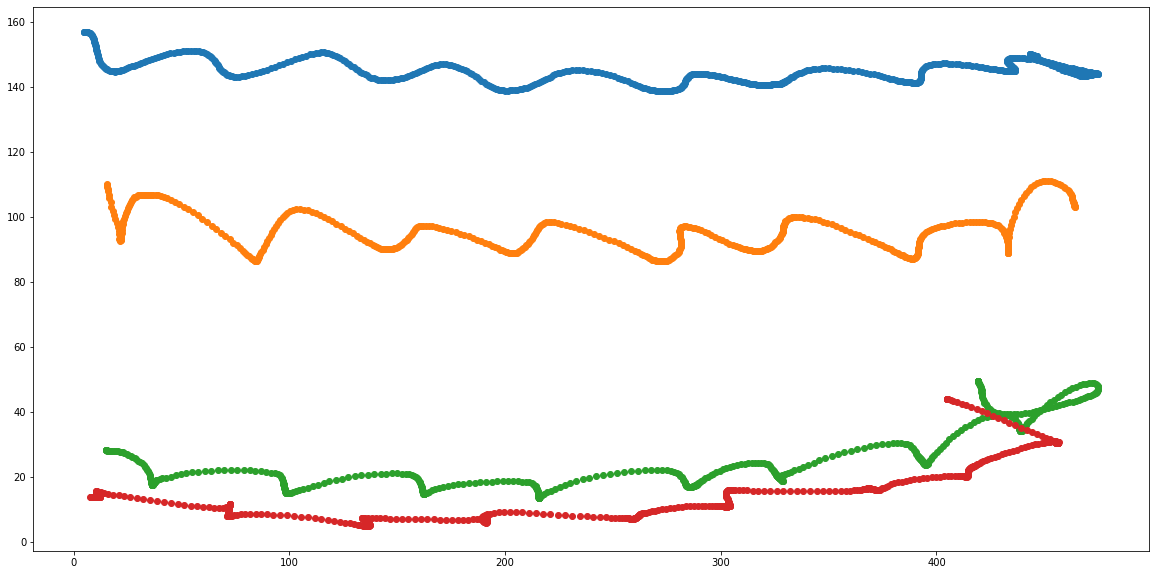

In [217]:

for i in (0, 2, 4, 6):
    segnali[i]=segnali[i][0:segnali[i+1].size]
    segnali[i+1]=segnali[i+1][0:segnali[i].size]
    plt.plot_date(segnali[i], segnali[i+1], xdate=False)

plt.show()

## Gif

Vado a creare una gif rappresentante i movimenti della gamba nel tempo.

In [218]:
#importo le librerie necessarie
import matplotlib.animation as animation
from IPython import display

Ora inizializzo il grafico: i valori limite del grafico sono i valori massimi e minimi dei segnali.

Per esempio il valore minimo delle x del grafico sarà il valore minimo di tutti i valori x dei segnali.

In [219]:
min_x=min(min(segnali[0]),min(segnali[2]),min(segnali[4]),min(segnali[6]))
max_x=max(max(segnali[0]),max(segnali[2]),max(segnali[4]),max(segnali[6]))
min_y=min(min(segnali[1]),min(segnali[3]),min(segnali[5]),min(segnali[7]))
max_y=max(max(segnali[1]),max(segnali[3]),max(segnali[5]),max(segnali[7]))

Creo l'area sulla quale verrà plottata la gif della gamba.

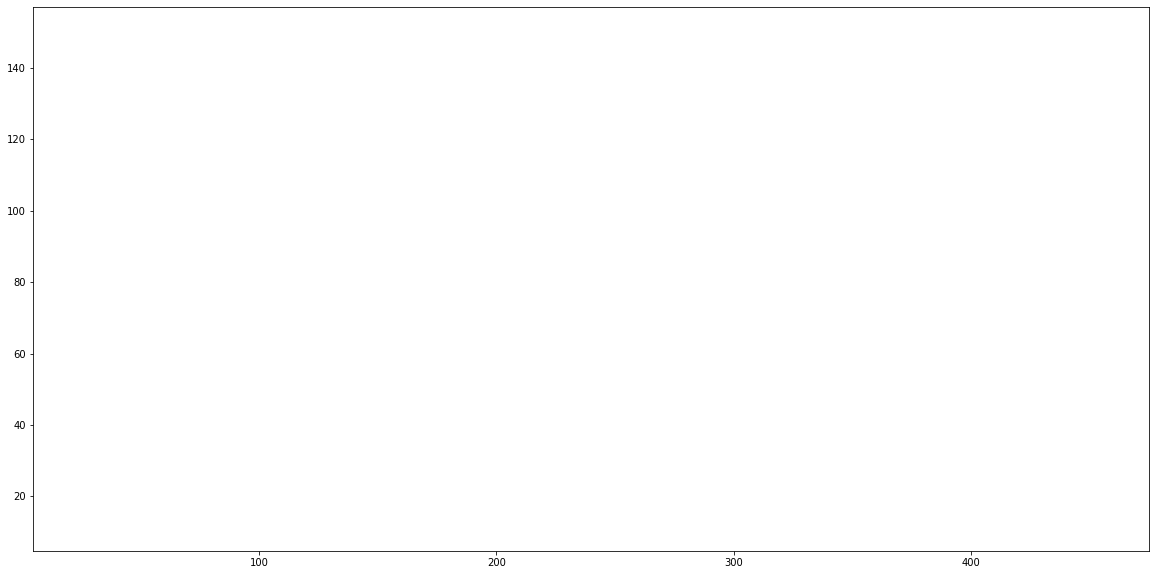

In [220]:
fig = plt.figure()
axis = plt.axes(xlim = (min_x, max_x),
                ylim = (min_y, max_y))

line, = axis.plot([], [], lw = 2)

Creo la funzione di inizializzazione.

In [221]:
def init():
    line.set_data([], [])
    return line,

Creo la funzione che andrà a restituire i singoli valori delle x e y dei segnali per ogni frame:

Ora creo la Gif e la salvo:

In [222]:

frames=len(segnali[0])#da controllare
print(frames)

anim = animation.FuncAnimation(fig, animate,
                            init_func = init,
                            frames=frames,
                            interval = 20,
                            blit = True)
plt.show()

583


In [223]:
anim.save('gamba.mp4', writer = 'ffmpeg', fps = 30)

## Numero passi per gamba

Può essere interessante vedere se il paziente fa più passi con una gamba rispetto all'altra.

Conto i picchi nella derivata prima i quali corrispondono al numero di passi del soggetto.

Prima analizzo la gamba sinistra:

In [224]:
segnali=getData(percorso+"/Pazienti/522_01_L_joints.mat")

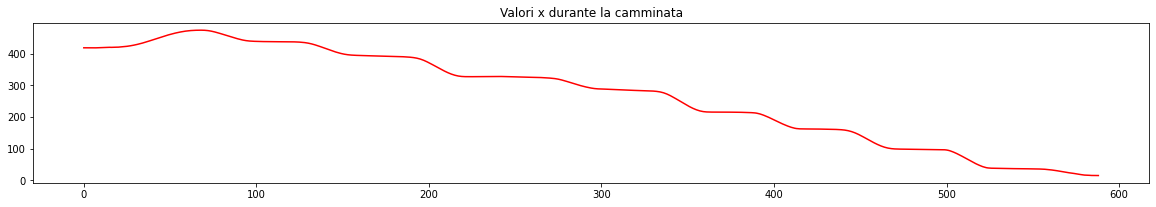

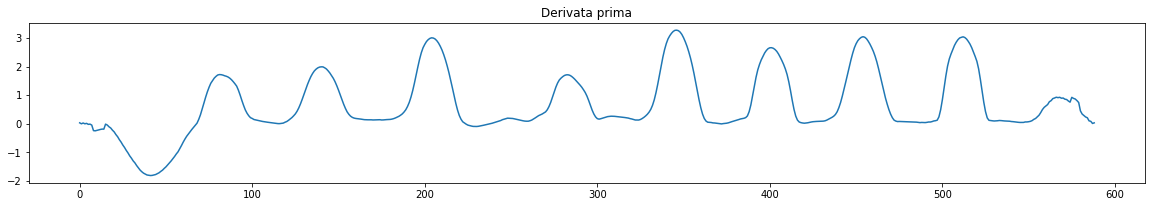

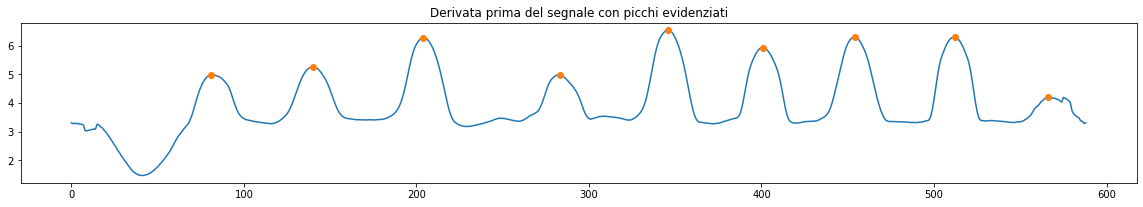

### Il numero di passi della gamba sinistra del paziente 522 è: 9

In [225]:
md("### Il numero di passi della gamba sinistra del paziente 522 è: {}".format(len(peaksFinder(segnali, 4))))

In [226]:
segnali=getData(percorso+"/Pazienti/522_01_R_joints.mat")

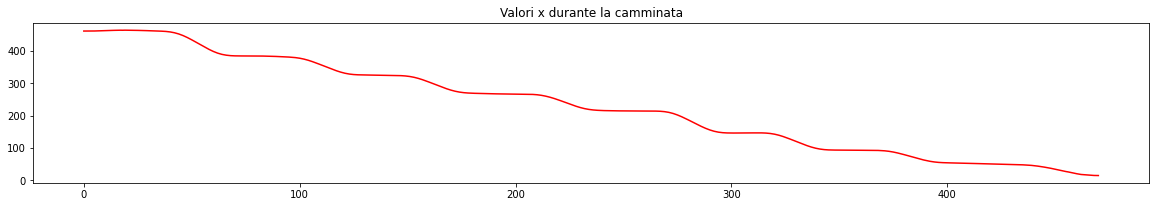

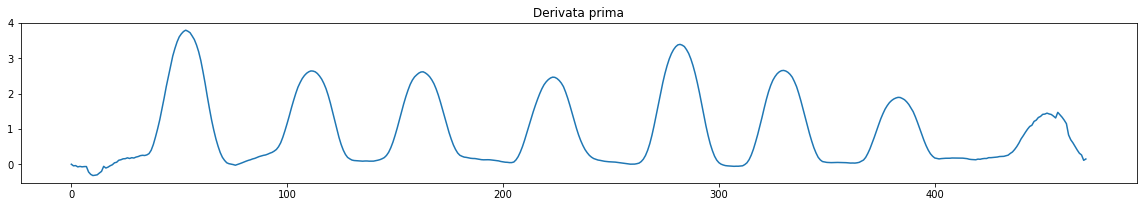

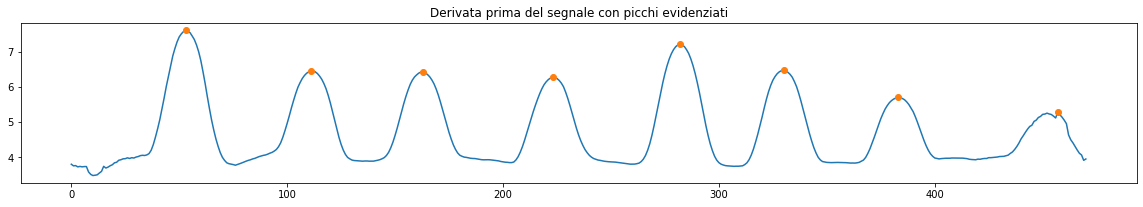

### Il numero di passi della gamba destra del paziente 522 è: 8

In [227]:
md("### Il numero di passi della gamba destra del paziente 522 è: {}".format(len(peaksFinder(segnali, 4))))

Il motivo per cui il soggetto fa un passo in più con la gamba sinistra potrebbe essere dovuto a disturbi motori ma anche dal fatto che potrebbe aver cominciato a camminare entrambe le volte facendo il primo passo con la gamba sinistra e che quindi quando i venivano rilevati i sensori della gamba destra è stato rilevato un passo in meno. 

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Distanza tra i passi

Andiamo ora ad analizzare le differenze tra la camminata dei soggetti sani e quella dei pazienti.

Come prima cosa analiziamo la distanza in termini di tempo tra i passi, la mia ipotesi è che i pazienti facciano passi più lunghi rispetto ai soggetti sani.

Per far capire i passi dell'analisi la applico prima su un paziente e su un soggetto sano e poi la estendo a tutti gli altri.

Plotto i valori che assume la caviglia del paziente che stamo analizzando (522_01_L).

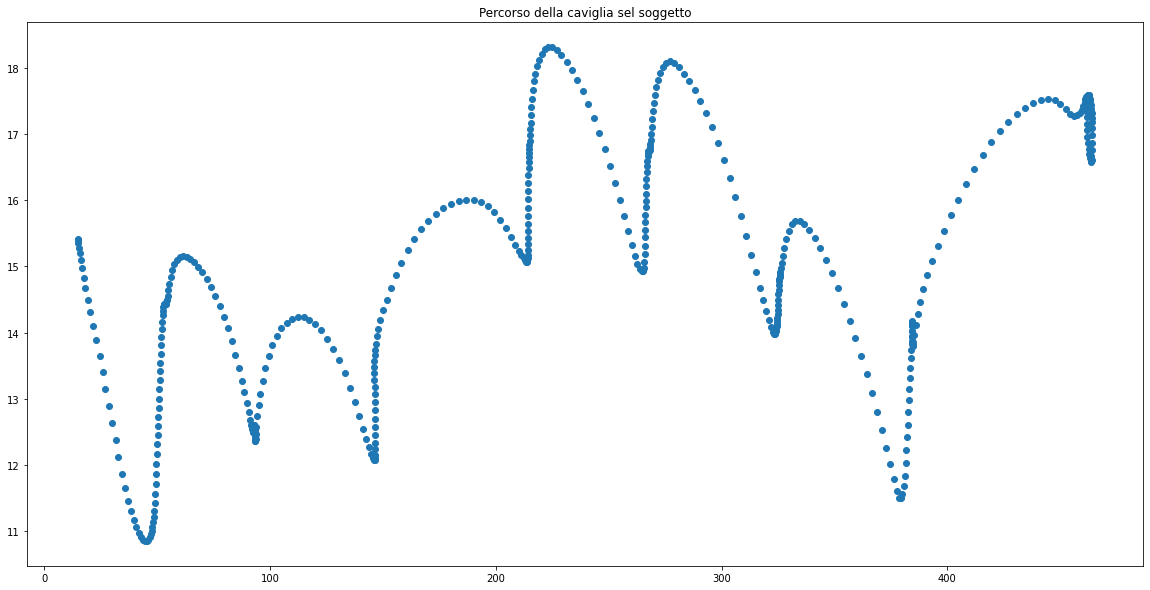

In [228]:

plt.title("Percorso della caviglia sel soggetto")
plt.plot_date(segnali[4], segnali[5],xdate=False)
plt.show()

In [229]:
segnali=getData(percorso+"/Pazienti/241_02_L_joints.mat")

Calcolo ora la derivata dei valori delle x assunti dalla caviglia del paziente durante la camminta, in questo modo potrò rilevare i picchi e quindi il momento di inizio/fine del passo.

La distanza tra i picchi è il tempo intercorso tra un passo e un altro (o meglio da metà di un passo a metà di quello dopo).

Non considero i picchi con distanza inferiore a 10 frame dal momento che non possono identificare dei passi ma piuttosto sono dovuti ad errori di misurazione da parti dei sensori o da tremori della caviglia.

Questi sono i picchi:

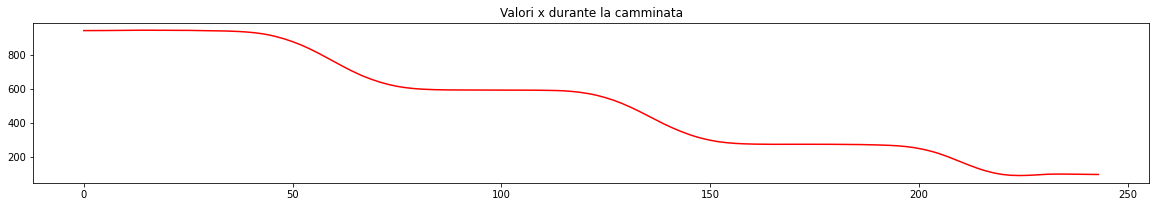

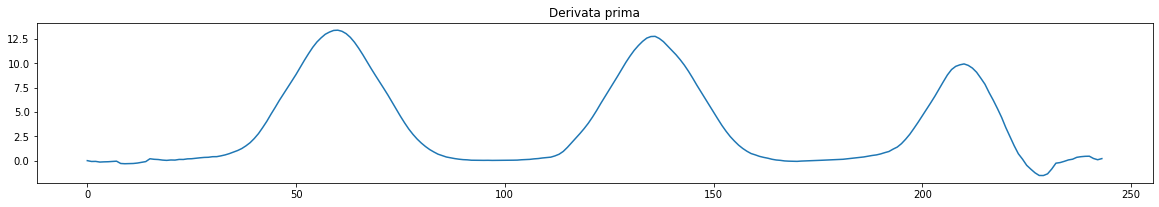

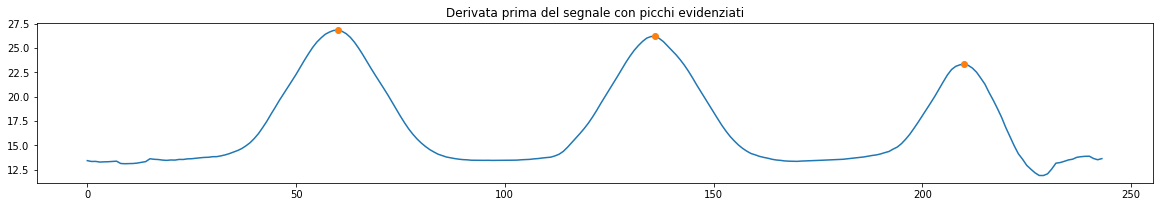

[ 60 136 210]


In [230]:
peaks=peaksFinder(segnali, 4)
print(peaks)

La distanza tra uno e l'altro è:

In [231]:
dist=[]
for i in range(len(peaks)-1):
    dist.append(abs(peaks[i]-peaks[i+1]))
print(dist)

[76, 74]


Misuro la distanza media:

In [232]:
n=int(np.mean(dist))
md("### In media la distanza tra un passo e l'altro è del paziente è di {} frame che corrispondono a {} secondi".format(n, n/25))

### In media la distanza tra un passo e l'altro è del paziente è di 75 frame che corrispondono a 3.0 secondi

Andiamo a vedere la distanza tra un passo e l'altro di un soggetto sano.

Carico i dati del soggetto S004_sx:

In [233]:
segnaliSano=getData(percorso+"/S005_sx.mat")

Plotto il movimento della caviglia:

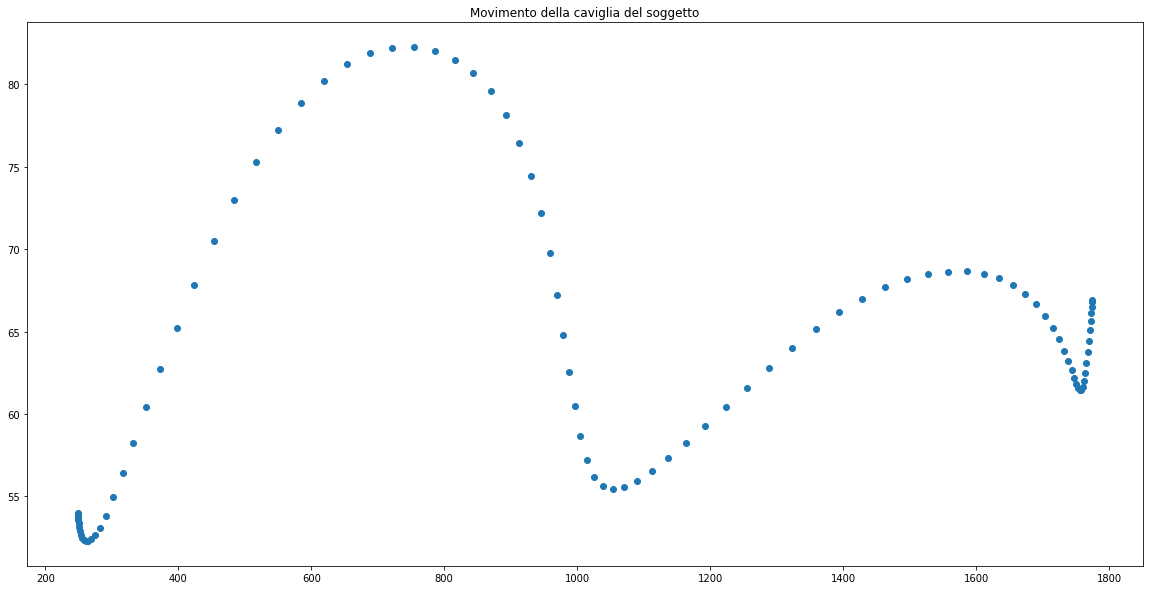

In [234]:
plt.title("Movimento della caviglia del soggetto")
plt.plot_date(segnaliSano[4], segnaliSano[5],xdate=False)
plt.show()

Calcolo come prima la derivata dei valori delle x assunti dalla caviglia del soggetto durante la camminta, per identificare i passi.

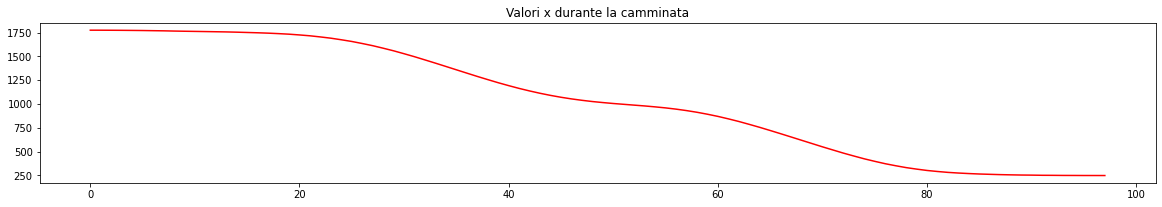

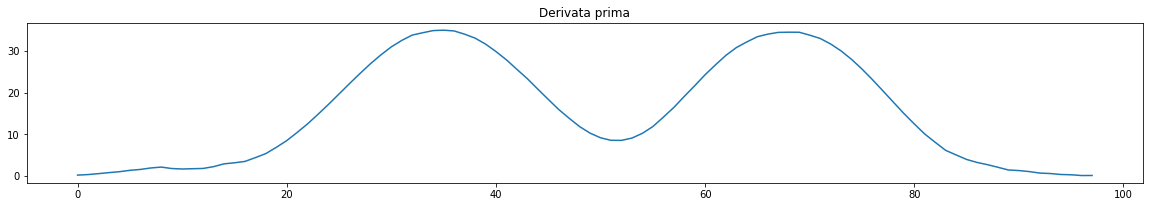

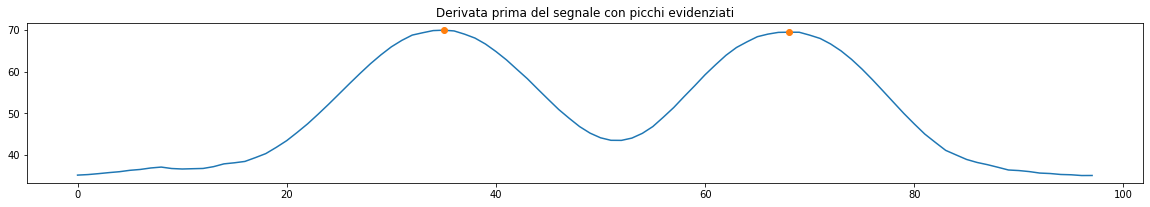

[35 68]


In [235]:
peaks=peaksFinder(segnaliSano, 4)
print(peaks)

Misuro la distanza media tra i picchi:

In [236]:
dist=[]
for i in range(len(peaks)-1):
    dist.append(abs(peaks[i]-peaks[i+1]))
n=int(np.mean(dist))
md("### In media la distanza tra un passo e l'altro è del soggetto sano è di {} frame che corrispondono a {} secondi".format(n, n/25))

### In media la distanza tra un passo e l'altro è del soggetto sano è di 33 frame che corrispondono a 1.32 secondi

Come ipotizzato il paziente analizzato ci mette più tempo a fare un passo rispetto al soggetto sano.

Estendiamo ora l'analisi a tutti i pazienti e a tutti i soggetti sani.

In [237]:
tempo=tempoPasso(percorso+"/Pazienti/*.mat")
md("### In media i pazienti impiegano {} secondi a fare un passo".format(tempo))

### In media i pazienti impiegano 1.9015384615384616 secondi a fare un passo

In [238]:
tempo=tempoPasso(percorso+"/*.mat")
md("### In media i soggetti sani impiegano {} secondi a fare un passo".format(tempo))

### In media i soggetti sani impiegano 1.305 secondi a fare un passo

Direi che la nostra ipotesi è confermata, i pazienti tendono a fare passi più lunghi in termini di tempo ripetto ai soggetti sani.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Tempo in cui il piede rimane a terra

Andiamo ora ad analizzare per quanto tempo il soggetto tiene il piede poggiato a terra durante la camminata.

La mia ipotesi è che i pazienti tengano il piede poggiato a terra più a lungo rispetto ai soggetti sani.

Sfruttando la derivata posso capire quando il piede sta fermo e quindi quando è poggiato a terra.

Come prima andrò ad analizzare prima un paziente e poi estenderò l'analisi a tutti gli altri soggetti.

Cominciamo dal paziente 241_02_R

In [239]:
segnali=getData(percorso+"/Pazienti/241_02_R_joints.mat")

Calcolo la derivata prima dei valori delle x assunti dalla caviglia del paziente durante la camminta, per vedere quando è vicnia allo 0 e di conseguenza quando il piede è fermo.

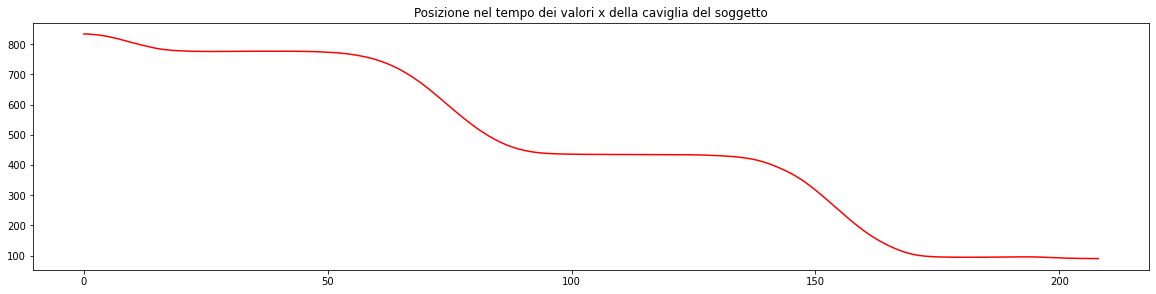

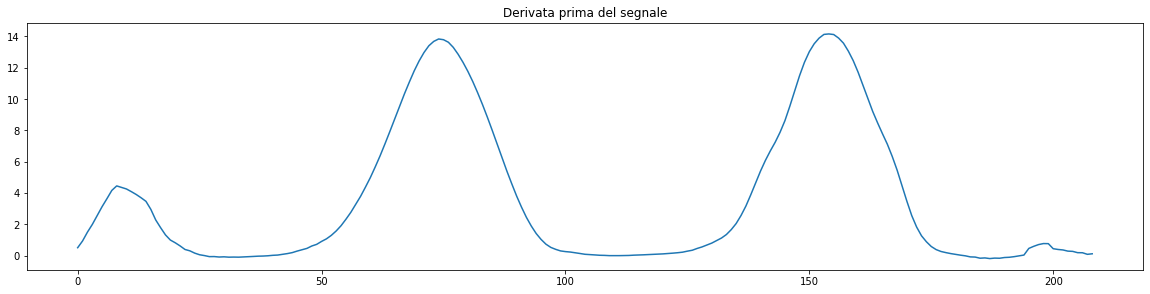

In [240]:
plt.subplot(2,1,1)
plt.title("Posizione nel tempo dei valori x della caviglia del soggetto")
plt.plot(segnali[4], "r")
plt.show()

der=np.gradient(-segnali[4])

plt.subplot(2,1,2)
plt.title("Derivata prima del segnale")
plt.plot(der)
plt.show()

Trovo ora i frame dove la derivata è molto vicina a 0:

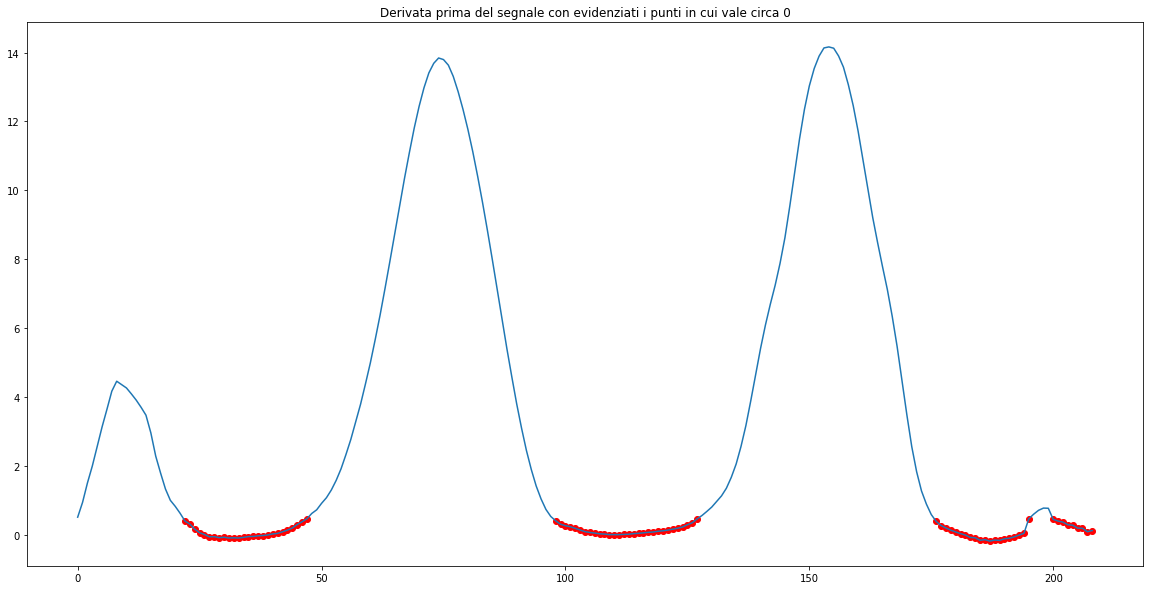

[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 200, 201, 202, 203, 204, 205, 206, 207, 208]


In [241]:
frames=[]
frame=0
for point in der:
    if point<0.5 and point>-0.5:
        plt.plot(frame,point, marker="o", color="red")
        frames.append(frame)
    frame+=1

plt.title("Derivata prima del segnale con evidenziati i punti in cui vale circa 0")
plt.plot(der)
plt.show()

print(frames)

Ora divido in gruppi i frame nei quali il piede è a terra tra un passo e l'altro, infatti se la distanza tra un frame e quello dopo è maggiore di un certo numero significa che il soggetto ha fatto un passo e che ora il piede è di nuovo a terra. 

Due valori appartengono a passi differenti se distanti più di 5 frame.

In [242]:
terra=np.asarray(piedeTerra(frames))
print(terra)

[array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
        39, 40, 41, 42, 43, 44, 45, 46, 47])
 array([ 98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
        111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
        124, 125, 126, 127])
 array([176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
        189, 190, 191, 192, 193, 194, 195, 200, 201, 202, 203, 204, 205,
        206, 207, 208])                                                 ]


Risultano esserci 3 passi e effettivamente guardando il plot sembra essere così.

Ora calcolo la media dei tempi in cui il piede rimane a terra

In [243]:
media = mediaTerra(terra)
md("### In media il piede durante la camminata sta poggiato a terra per {} secondi".format(media/25))

### In media il piede durante la camminata sta poggiato a terra per 1.1333333333333333 secondi

Ora eseguo la stessa procedura prima con tutti i pazienti e poi con tutti i soggetti sani per confrontare così i risultati.

In [244]:
tempo=frameTerra(percorso+"/Pazienti/*.mat")
md("### In media i pazienti durante la camminata tengono poggiato il piede per {} secondi ".format(tempo))

### In media i pazienti durante la camminata tengono poggiato il piede per 0.6708453768453768 secondi 

In [245]:
tempo=frameTerra(percorso+"/*.mat")
md("### In media i soggetti sani durante la camminata tengono poggiato il piede per {} secondi".format(tempo))

### In media i soggetti sani durante la camminata tengono poggiato il piede per 0.22 secondi

## Altezza dei passi (fallita)

Andiamo ora a confrontare le altezza dei passi dei soggetti sani con quelle dei pazineti.

La mia ipotesi è che i pazienti facciano passi meno alti rispetto ai soggetti sani.

Plotto i valori della caviglia sull'asse y

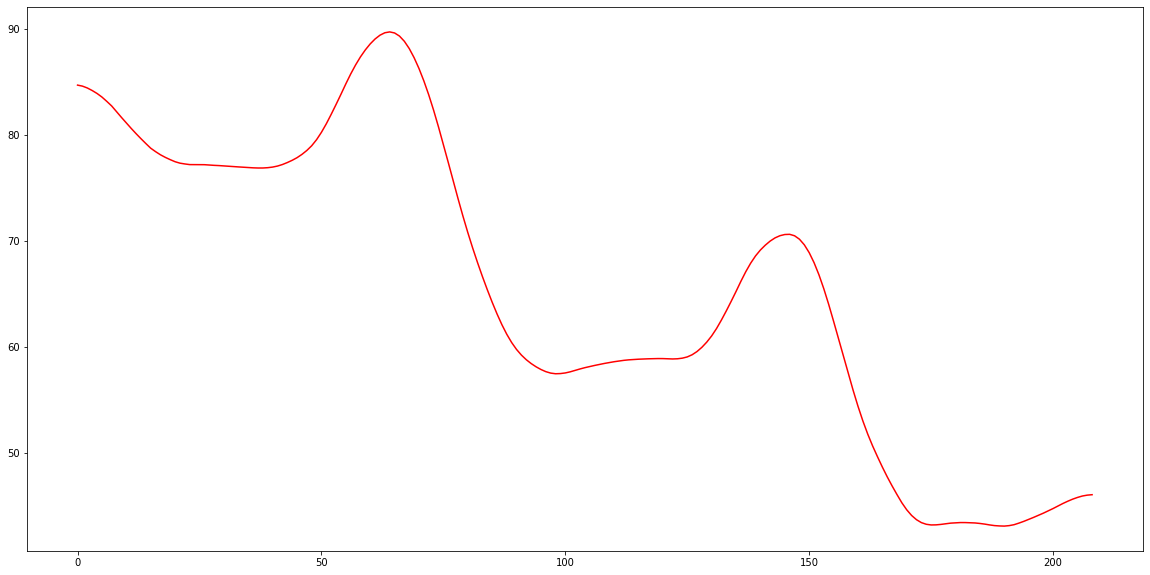

In [246]:
plt.plot(segnali[5], "r")
plt.show()

Ora trovo i picchi e le valli. Il valore dei picchi è ottenuto sottraendo all'altezza del picco il valore più basso delle y, in questo modo il picco indica l'altezza del passo.

Picchi:

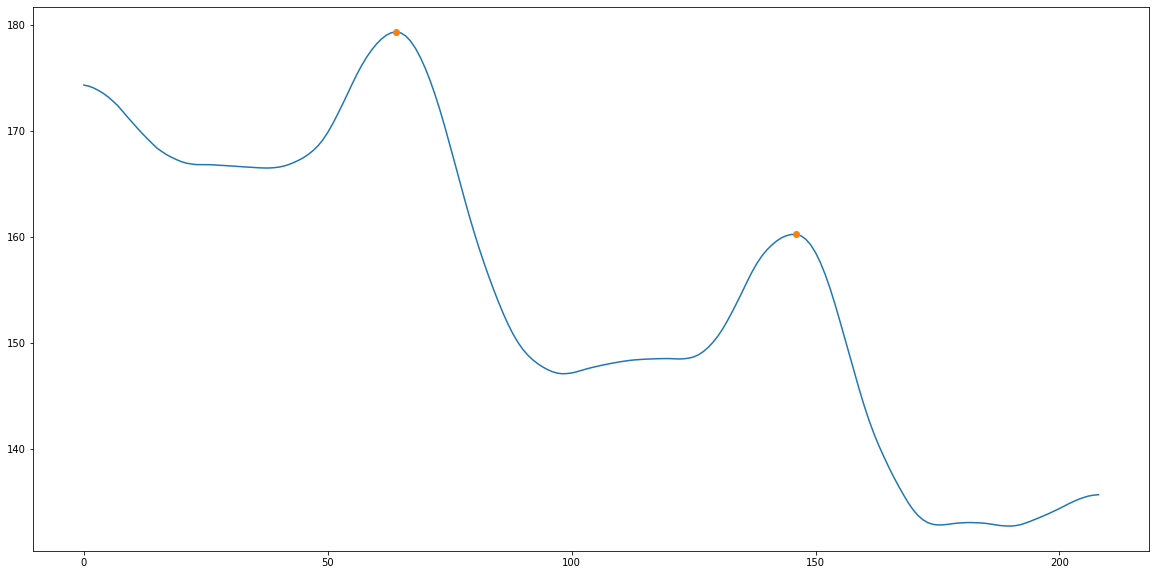

[46.61026958 27.51851819]


In [247]:
peaks=altezza(segnali[5])
peaks=peaks-min(segnali[5])
print(peaks)

Valli:

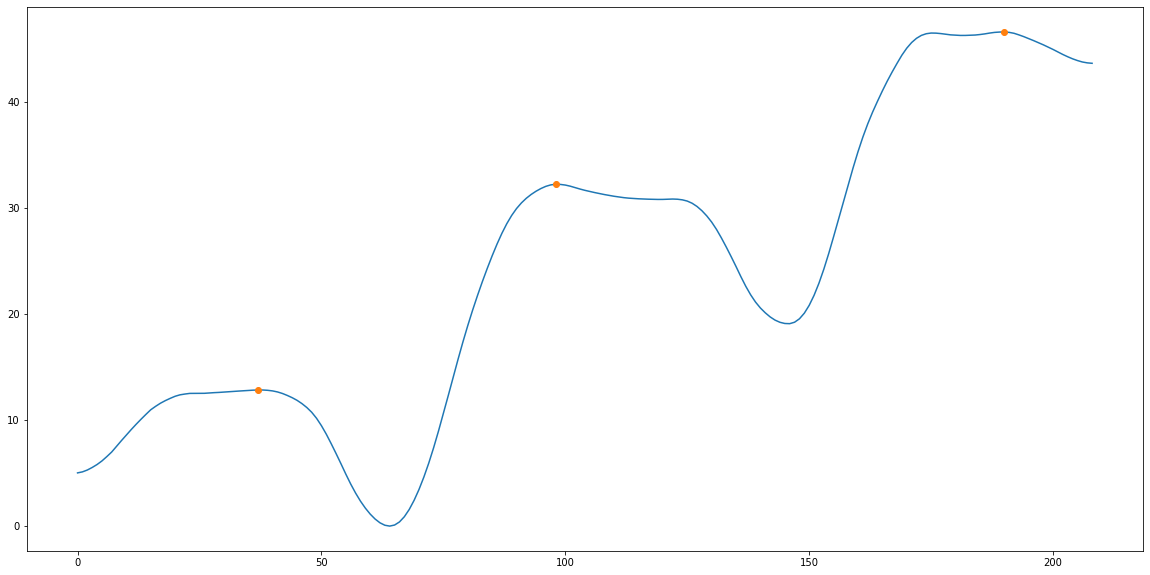

[12.835917625834725, 32.24160301207547, 46.61026957505695]


In [248]:
valleys=altezza(-segnali[5])
print(valleys)

Prendo il primo picco e la seconda valle e calcolo la distanza tra i due:

In [249]:
altezza=abs(peaks[0]-valleys[1])
print(altezza)

14.368666562981474


A questo punto sorge un problema: il pazinete stava camminando non parallelamente alla telecamera e quindi i passi non sono "omogenei" nel senso che, come possiamo vedere la plot precedente, il piede sale di un certo tot ma poi scende di più di quanto era salito. E' come se il soggetto stesse scendendo una scala e quindi viene difficile calcolare l'altezza del passo.

L'altezza dei passi posso calcolarla di conseguenza in un soggetto del quale so se ha camminato parallelo o meno alla telecamera quindi non posso estenderla a tutti gli altri per vedere le differenze tra le altezze dei passi dei soggetti sani e dei pazineti.

Inoltre l'analisi dell'altezza dei passi di un singolo soggetto è poco indicativa dato che non ho un'unità di misura che mi identifichi i valori dell'asse y quindi ha poco senso farla.

# Conclusioni:

Le analisi effettuate circa la distanza dei passi e il tempo di appoggio sembrano confermare ipotesi sensate quindi mi reputo soddisfatto delle analisi effettuate. Riguardo all'altezza dei passi purtroppo ho dovuto rinunciare per via dei problemi visti prima non potendo quindi confermare la mia ipotesi.